# Embedding Model

In [44]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [47]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


## Linear Embedding Model

In [48]:
class EmbeddingModel:
    def __init__(self, input_dim, embedding_dim, learning_rate=0.001, dropout_rate=0.2):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self._build_model()
    
    def _build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(128, activation='relu')(input_layer)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        embedding_layer = Dense(self.embedding_dim, activation='relu')(x)  # This layer serves as the embedding
        x = Dropout(self.dropout_rate)(embedding_layer)
        x = Dense(64, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        output_layer = Dense(self.input_dim, activation='linear')(x)

        # Create the MLP model
        self.encoder = Model(inputs=input_layer, outputs=output_layer)
        
        # Create a separate model for extracting embeddings
        self.embedding_model = Model(inputs=input_layer, outputs=embedding_layer)
        
        # Compile the MLP model
        self.encoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
    
    def train(self, data, epochs=100, batch_size=64, patience=10):
        early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            self.encoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping])
    
    def get_embeddings(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            return self.embedding_model.predict(data)

In [49]:
# Preprocess the data

# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

In [50]:
features_df

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
...,...,...,...,...,...,...,...,...,...,...,...
99995,1.000000,0,1,0,0,0,0,1,0,0.475269,0.683419
99996,0.666667,0,0,0,0,0,0,1,0,0.562420,0.861997
99997,0.666667,0,1,0,0,0,0,1,0,0.225903,0.243447
99998,0.333333,0,1,1,0,0,0,0,0,0.073531,0.058008


In [51]:
# Initialize and train the autoencoder model
input_dim = score_features.shape[1]
embedding_dim = 2  # Embedding dimension of 2 to make it easy to plot the resulting embeddings on a 2D scatter plot

In [53]:
embedding_model = EmbeddingModel(input_dim=input_dim, embedding_dim=embedding_dim, dropout_rate=0.2)
embedding_model.train(score_features, epochs=100, batch_size=64, patience=10)

Epoch 1/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0235
Epoch 2/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0150
Epoch 3/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0131
Epoch 4/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0126
Epoch 5/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0122
Epoch 6/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0119
Epoch 7/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0115
Epoch 8/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0115
Epoch 9/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0113
Epoch 10/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0111
Epoch 11/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0110
Epoch 12/100
1563/1563 [==============================] - 4s 2ms/step - lo

In [54]:
embeddings = embedding_model.get_embeddings(score_features)

3125/3125 [==============================] - 2s 590us/step


## Determine the number of clusters(k)

In [56]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


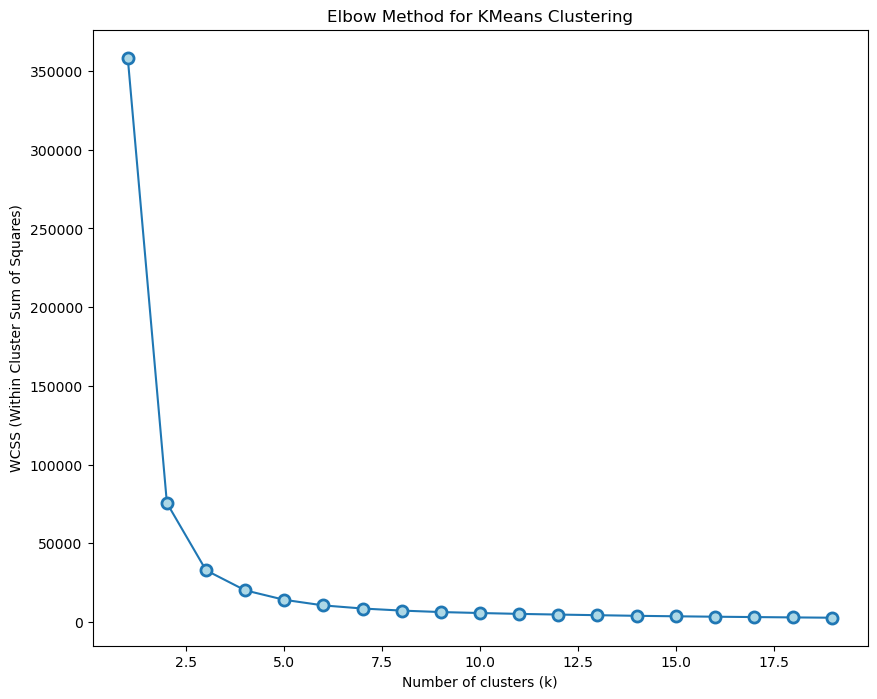

In [57]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [58]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df['cluster_kmeans'] = kmeans.predict(embeddings)
df.groupby(['cluster_kmeans']).mean()

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
cluster_kmeans,,,,,,,,,,,
0,0.605293,0.823022,0.297075,0.076425,0.149751,0.124343,0.072180,0.460035,0.117266,0.805613,0.828701
1,0.465112,0.728307,0.592689,0.077050,0.130166,0.163775,0.107414,0.429796,0.091799,0.315781,0.223067
2,0.530043,0.794073,0.319676,0.071116,0.142093,0.146748,0.086924,0.443610,0.109508,0.600517,0.643645


In [ ]:
# df.mean()

In [59]:
df.cluster_kmeans.value_counts()

1    63465
2    21697
0    14838
Name: cluster_kmeans, dtype: int64

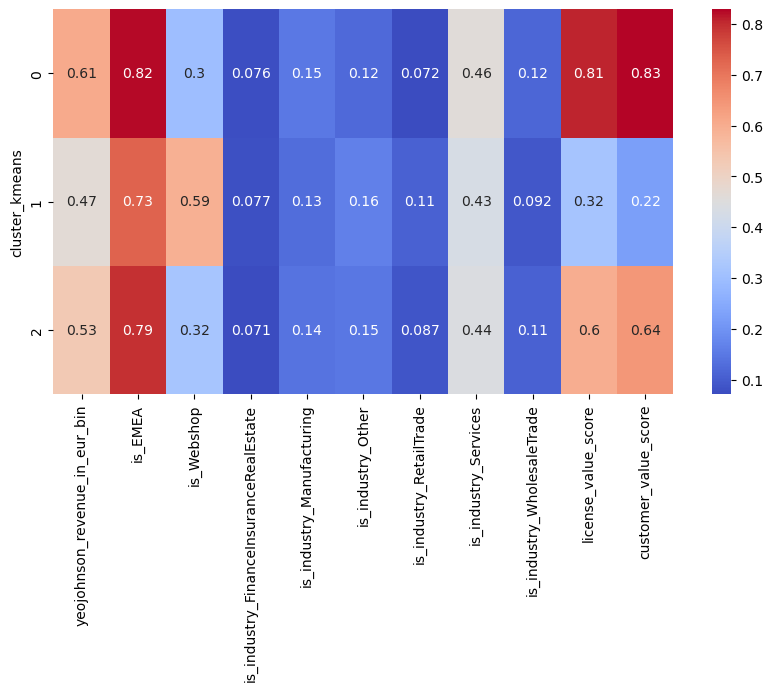

In [60]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [61]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)
fig.show()

## Evaluation

In [62]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(scores_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.374


In [63]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(scores_df, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 1.062


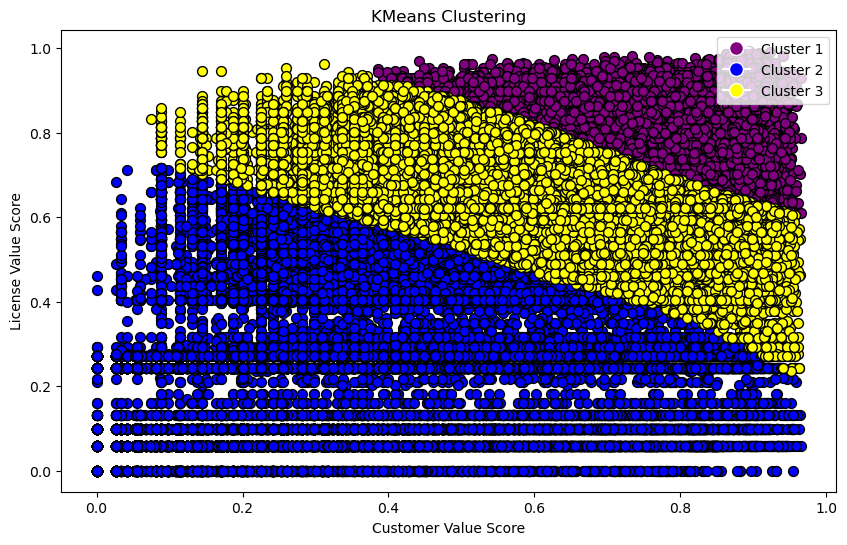

In [67]:
# Define colors for each cluster
cluster_colors = ['purple', 'blue', 'yellow', 'green']

# Plot the clusters using the first two features
plt.figure(figsize=(10, 6))

# Scatter plot of the data points, colored by cluster label
for i in range(kmeans.n_clusters):
    plt.scatter(score_features[:, -2][cluster_labels == i], score_features[:, -1][cluster_labels == i], color=cluster_colors[i], 
                label=f'Cluster {i+1}', marker='o', edgecolor='k', s=50)

# Scatter plot of the data points
# plt.scatter(score_features[:, -2], score_features[:, -1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50)

# Scatter plot of the cluster centers
# plt.scatter(cluster_centers[:, -2], cluster_centers[:, -1], c='red', marker='x', s=200, linewidths=3, edgecolor='k', label='Cluster Centers')

# Create custom legend for clusters
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}', 
                          markerfacecolor=cluster_colors[i], markersize=10) for i in range(kmeans.n_clusters)]
# legend_elements.append(Line2D([0], [0], marker='x', color='w', label='Cluster Centers', 
#                               markerfacecolor='red', markersize=10, linestyle='None', markeredgewidth=2))

# Add titles, labels and legend
plt.legend(handles=legend_elements, loc='upper right')
plt.title('KMeans Clustering')
plt.xlabel('Customer Value Score')
plt.ylabel('License Value Score')

# Show plot
plt.show()